In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import os
import sys
from torch.utils.data import DataLoader
from patsy import dmatrix
import torch
sys.path.append(os.path.abspath('../src'))

from data_tools.data_utils import create_data_split

In [5]:
project_dir = project_dir = Path.cwd().parent
trunc_D = 40

create_data_split(
    start_year=2013,
    end_year=2020,
    D=trunc_D,
    data_folder_path = project_dir / "data",
    input_filename="DENGSP.csv",
    train_prop=0.7,
    val_prop=0.2,
    test_prop=0.1
)

complete_df = pd.read_csv(project_dir / "data" / "model" / "complete_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_utils.py:19: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf_raw = pd.read_csv(input_data_path, index_col=0)


In [15]:
class ReportingDataset():
    def __init__(self, df, D):
        self.df = df.copy()
        self.D = D
        self.max_val = self.df.values.max()
    
    def get_obs(self, idx, n_points, norm=False, mask=False):
        # Ignore first D days to ensure full matrix
        t = idx + self.D


        # Create reporting triangle for day t
        matrix = self.df.iloc[t - n_points + 1: t + 1, :self.D].values
        
        # Mask last D days
        if mask:
            matrix[-self.D:] = self.mask_matrix(matrix[-self.D:])

        if norm:
            return matrix / self.max_val
        else:
            return matrix
    
    def get_y(self, idx):
        t = idx + self.D
        return self.df.iloc[t].sum()

    def get_date(self, idx):
        t = idx + self.D
        return self.df.index[t]


    def get_past_triangles(self, idx, n_points=1, norm=True):
        assert n_points >= 1, "n must be non-negative"
        assert idx + 1 >= n_points, "idx must be at least as big as number of points"
        triangles = np.zeros(shape=(n_points, self.D, self.D))
        t_vals = np.arange(idx-n_points+1, idx+1)
        for i, t in enumerate(t_vals):
            triangles[i, :, :] = self.get_obs(t, n_points=self.D, norm=norm)

        return triangles

    def get_masked_matrix(self):
        mask_matrix = np.ones(shape=(self.D, self.D), dtype=bool)
        for i in range(self.D):
            for j in range(self.D):
                if i + j > self.D - 1:
                    mask_matrix[i, j] = False
        return mask_matrix


data_obj = ReportingDataset(complete_df, D=trunc_D)

In [7]:
print(complete_df.index[2132])
print(complete_df.index[2844 - 41])
len(complete_df)

2018-12-12
2020-10-13


2844

* point plots of actual on X with prediction on Y, differnt models in different facets
* Evaluate forecasting methods across variety of metrics:
    * CRPS
    * IS
    * WIS
    * PICA

Pre-Compile model

In [243]:
def silu(x):
    return x * pm.math.sigmoid(x)


def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        init="adapt_diag",
        chains=2,
        draws=500,
        tune=500,
        target_accept=0.95,
        max_treedepth=10,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"}
    )

def run_BNN_model(data_obj, obs, triangles_flat, X_trend, X_week, t_model, t_week, mask_matrix, progressbar=False):
    with pm.Model() as model:
        T, D = obs.shape

        # # Weekly and trend spline model for log_lambda
        # sigma_trend = pm.HalfNormal("sigma_trend", 2)
        # beta_trend = pm.Normal("beta_trend", mu=0, sigma=sigma_trend, shape=X_trend.shape[1])

        # sigma_week = pm.HalfNormal("sigma_week", 2)
        # beta_week = pm.Normal("beta_week", mu=0, sigma=sigma_week, shape=X_week.shape[1])

        # Linear Trend
        sigma_linear = pm.HalfNormal("sigma_linear", 2)
        beta_linear = pm.Normal("beta_linear", mu=0, sigma=sigma_linear, shape=(1))
        intercept = pm.Normal("intercept", mu=0, sigma=10)

        # AR residuals
        order = 2
        coefs = pm.Normal("coefs", 0, size=order)
        init = pm.Normal.dist(mu=0, sigma=1, shape=order)
        ar = pm.AR("ar", rho=coefs, sigma=1.0, init_dist=init, constant=False, shape=T)

        # log_lam = pm.Deterministic(
        #     "log_lam", pm.math.dot(X_trend, beta_trend) + pm.math.dot(X_week, beta_week) + intercept 
        # )
        log_lam = pm.Deterministic(
            "log_lam", beta_linear * t_model + intercept + ar
        )

        lam = pm.Deterministic("lam", pm.math.exp(log_lam))

        # NN for proportions
        n_hidden = 8
        net_sd = 0.25
        W1 = pm.Normal("W1", 0, net_sd, shape=(data_obj.D * data_obj.D, n_hidden))
        b1_net = pm.Normal("b1_net", 0, net_sd, shape=(n_hidden,))
        h1 = silu(pm.math.dot(triangles_flat, W1) + b1_net)

        W2 = pm.Normal("W2", 0, net_sd, shape=(n_hidden, data_obj.D))
        b2_net = pm.Normal("b2_net", 0, net_sd, shape=(data_obj.D,))
        p_raw = pm.math.dot(h1, W2) + b2_net

        t_week_onehot = np.eye(7)[t_week]
        W_dow = pm.Normal("W_dow", 0, net_sd, shape=(7, data_obj.D))
        p_dow = pm.math.dot(t_week_onehot, W_dow)
        

        p_raw = pm.math.clip(p_raw + p_dow, -15, 15)
        p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=1))

        log_mu = pm.math.log(lam[:, None]) + pm.math.log(p + 1e-6)
        mu = pm.Deterministic("mu", pm.math.exp(log_mu))
        mu_clipped = pm.math.clip(mu, 1e-3, 1e5)

        
        alpha = pm.Exponential("alpha", 3)
        z = pm.NegativeBinomial("z", mu_clipped[mask_matrix], alpha, observed=obs[mask_matrix])
        
        idata = pm.sample(progressbar=progressbar, **sampler_kwargs())

    return idata


In [244]:
# Constants
n_points = 50
t_model = np.arange(0, n_points)
t_week = t_model % 7
spline_trend = dmatrix(
    "bs(t, df=10, degree=3, include_intercept=False)", {"t": t_model}, return_type='dataframe'
)
X_trend = np.asarray(spline_trend)

spline_week = dmatrix(
    "cc(t_week, df=7)", {"t_week": t_week}, return_type='dataframe'
)
X_week = np.asarray(spline_week)

# Create mask
mask_matrix = np.ones((n_points, data_obj.D), dtype=bool)
if n_points > data_obj.D:
    mask_matrix[-data_obj.D:,:] = data_obj.get_masked_matrix()
else:
    mask_matrix = data_obj.get_masked_matrix()[-n_points:,:]


In [245]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm


def run_single_t(t):
    obs = data_obj.get_obs(t, n_points)
    triangles = data_obj.get_past_triangles(t, n_points, norm=False)
    triangles_flat = triangles.reshape((n_points, data_obj.D * data_obj.D)) / triangles.max()

    idata = run_BNN_model(data_obj, obs, triangles_flat, X_trend, X_week, t_model, t_week, mask_matrix, progressbar=False)
    lam_post_samples = az.extract(idata, group='posterior', num_samples=1000)['lam']
    return lam_post_samples


# 2132- 2800

t1 = 2150
t2 = 2153
BNN_preds = Parallel(n_jobs=4)(
    delayed(run_single_t)(t) for t in tqdm(range(t1, t2))
)



100%|██████████| 3/3 [00:00<00:00, 1568.94it/s]


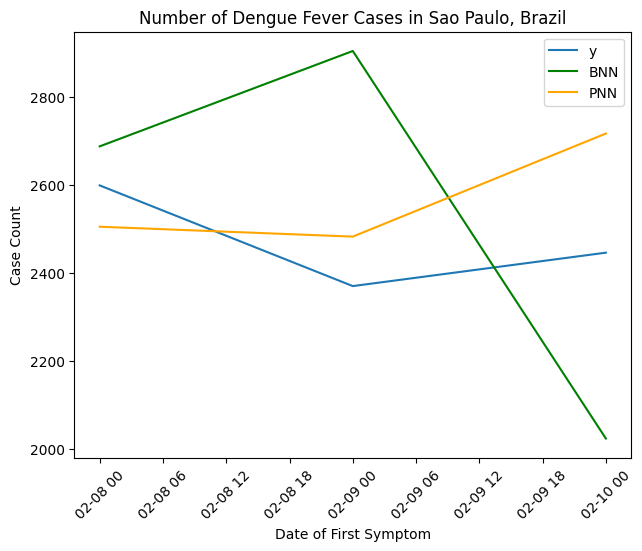

In [246]:


# Select sameday nowcast
BNN_forecasts = np.array(BNN_preds)[:,-1,:] 
BNN_preds_med = np.quantile(BNN_forecasts, 0.5, axis=-1) 

# BNN_preds_med = BNN_preds_med * data_obj.max_val

PNN_df = pd.read_csv(project_dir / "data" / "model" / "PNN_results.csv")
PNN_df = PNN_df.iloc[trunc_D + t1+1:trunc_D + t2+1]
PNN_preds = PNN_df['preds']

y_plot = [data_obj.get_y(idx) for idx in np.arange(t1, t2)]
dates = [pd.to_datetime(data_obj.get_date(idx)) for idx in np.arange(t1, t2)]


plt.plot(dates, y_plot, label='y')

plt.plot(dates, BNN_preds_med, label='BNN', color='green')
# plt.fill_between(dates, BNN_lower, BNN_upper, color='green', alpha=0.2, label='BNN 95% CI')



plt.plot(dates, PNN_preds, label='PNN', color='orange')
# plt.fill_between(dates, PNN_lower, PNN_upper, color='orange', alpha=0.2, label='PNN 95% CI')


plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.xticks(rotation=45)
plt.show()

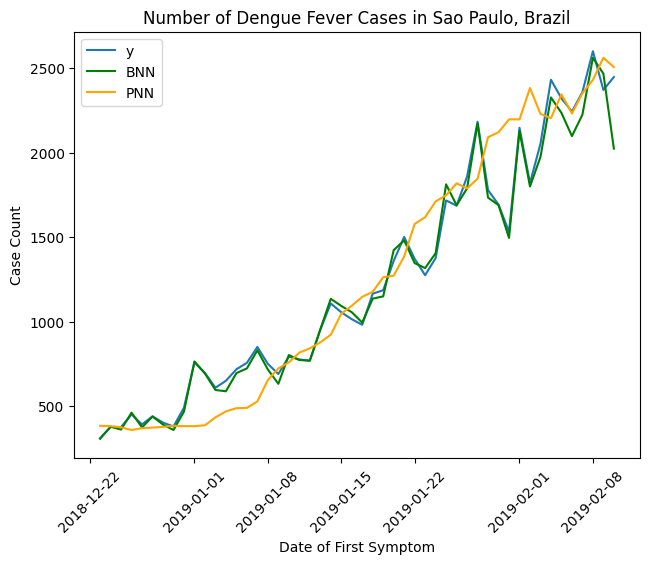

In [248]:
# Single period fit
rel_idx = 2
BNN_preds_med = np.quantile(BNN_preds[rel_idx], 0.5, axis=-1)

PNN_df = pd.read_csv(project_dir / "data" / "model" / "PNN_results.csv")
PNN_df = PNN_df.iloc[trunc_D + t1 - n_points + rel_idx:trunc_D + t1 + rel_idx]
PNN_preds = PNN_df['preds']

y_plot = [data_obj.get_y(idx) for idx in np.arange(t1-n_points + 1 + rel_idx, t1+ 1 + rel_idx)]
dates = [pd.to_datetime(data_obj.get_date(idx)) for idx in np.arange(t1-n_points + 1 + rel_idx, t1+1 + rel_idx)]


plt.plot(dates, y_plot, label='y')

plt.plot(dates, BNN_preds_med, label='BNN', color='green')
# plt.fill_between(dates, BNN_lower, BNN_upper, color='green', alpha=0.2, label='BNN 95% CI')



plt.plot(dates, PNN_preds, label='PNN', color='orange')
# plt.fill_between(dates, PNN_lower, PNN_upper, color='orange', alpha=0.2, label='PNN 95% CI')


plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.xticks(rotation=45)
plt.show()